# Chap3 线性回归

In [16]:
import os, random
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## 向量化加速

In [2]:
import math,time,torch
import numpy as np
from d2l import torch as d2l

In [3]:
n = 100000
a = torch.ones(n)
b = torch.ones(n)

In [4]:
class Timer:  #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

In [5]:
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.6f} sec'

'0.969761 sec'

In [6]:
timer.start()
d = a + b
f'{timer.stop():.6f} sec'

'0.000000 sec'

## 初步实现线性回归

### 生成数据集

In [7]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [8]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [9]:
labels.shape

torch.Size([1000, 1])

In [10]:
features[:,0].shape

torch.Size([1000])

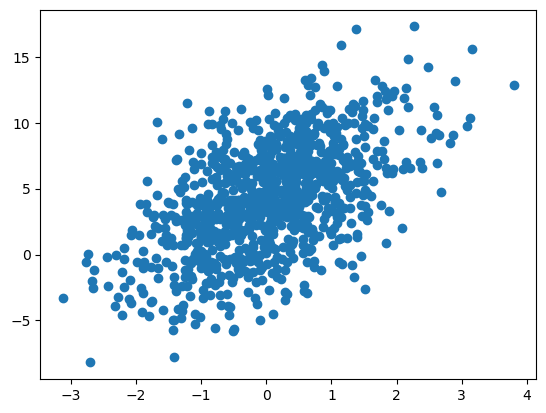

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(features[:, 0].numpy(),labels.squeeze().numpy())

### 读取数据集

In [14]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [17]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-2.7683, -0.2308],
        [ 0.8646,  0.5189],
        [ 0.3480,  0.2085],
        [ 0.5162, -0.9573],
        [ 0.7620,  0.1080],
        [ 1.4237,  0.1981],
        [ 0.1649,  1.6562],
        [ 1.6057,  0.8738],
        [ 0.5161,  0.4147],
        [-0.0646, -1.0697]]) 
 tensor([[-0.5648],
        [ 4.1456],
        [ 4.1945],
        [ 8.5008],
        [ 5.3624],
        [ 6.3593],
        [-1.0905],
        [ 4.4456],
        [ 3.8137],
        [ 7.7188]])


### 初始化模型参数，定义模型、损失函数和优化算法

In [18]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [19]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

### 训练

In [20]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [21]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.028074
epoch 2, loss 0.000102
epoch 3, loss 0.000050


In [22]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([0.0002, 0.0003], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0008], grad_fn=<RsubBackward1>)


## 线性回归的简洁实现

In [23]:
from torch.utils import data

In [25]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [26]:
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [27]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [28]:
next(iter(data_iter))

[tensor([[-0.6494, -0.1383],
         [ 0.2221, -0.0141],
         [-1.2694,  2.0290],
         [-1.0953, -3.1847],
         [ 0.2382, -1.2400],
         [-0.3508,  0.5090],
         [-0.5968, -0.3112],
         [-0.1983, -1.6921],
         [ 1.1852, -0.5266],
         [ 0.4557,  0.9872]]),
 tensor([[ 3.3861],
         [ 4.7037],
         [-5.2327],
         [12.8430],
         [ 8.8865],
         [ 1.7609],
         [ 4.0710],
         [ 9.5590],
         [ 8.3585],
         [ 1.7470]])]

In [29]:
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

loss = nn.MSELoss()

trainer = torch.optim.SGD(net.parameters(), lr=0.03)

### 训练

In [30]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000225
epoch 2, loss 0.000094
epoch 3, loss 0.000093


In [31]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

w的估计误差： tensor([ 1.2612e-04, -2.7895e-05])
b的估计误差： tensor([0.0003])
